# Constructing fire frequency and size data sets for different spatiotemporal scales

Author: Jatan Buch (v1, 210729) || (v2, 210824) || (v3, 210916) || (v4, 211112) || (v5, 220102)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from stats_utils import uni_lsq_regression_model, multi_regression_model

from datetime import datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params import params
import matplotlib.pylab as pylab
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

## Data pre-processing

In [2]:
data_dir= "../data/"
pred_input_path= "12km/"
resp_input_path= "firelist/"
outfilepath= "../plots/"

In [3]:
wildfire_df= pd.read_csv(data_dir + resp_input_path + "west_US_fires_1984_2020.txt", 
                         usecols= (0, 1, 9, 18, 19, 20, 21, 22, 23, 24), delimiter= ',') #west_US_fires_1984_2020.txt
#wildfire_df= wildfire_df[wildfire_df['final_area_ha'] > 404].reset_index()

wildfire_x, wildfire_y= coord_transform(wildfire_df['final_lat'], wildfire_df['final_lon'])

wildfire_df['final_x']= wildfire_x
wildfire_df['final_y']= wildfire_y

wildfire_gdf= gpd.GeoDataFrame(wildfire_df, crs= 'EPSG:5070', geometry=gpd.points_from_xy(wildfire_df['final_x'], wildfire_df['final_y']))

reg_indx_arr= update_reg_indx(wildfire_gdf)
l4indx_arr= update_reg_indx(wildfire_gdf, lflag= 'L4')

wildfire_df['reg_indx']= reg_indx_arr
wildfire_df['L4_indx']= l4indx_arr
grouped= wildfire_df.groupby(['reg_indx'])
#wildfire_df= wildfire_df.rename(columns={"reg_indx":"L3_indx"})
#wildfire_df.drop(columns= ['geometry']).to_hdf('../sav_files/wildfire_df_L3_L4_indx.h5', key= 'df', mode= 'w')

100%|███████████████████████████████████████████| 18/18 [00:26<00:00,  1.45s/it]


## Dataframe initialization

In [7]:
#file_io_func(firedf= wildfire_df, lflag= 'L4', fflag= 'freq', io_flag= 'output')
#file_io_func(firedf= wildfire_df, lflag= 'L4', fflag= 'freq', io_flag= 'input')
#tmpdf= pd.read_hdf('../data/clim_L4_fire_freq_data.h5')

In [4]:
%time data_df= init_fire_freq_df(firedf= wildfire_df)
#data_df.to_hdf(data_dir + 'clim_L3_fire_freq_data.h5', key= 'df', mode= 'w') 

Creating dataframe for ca_sierra
Creating dataframe for ca_north_coast
Creating dataframe for ca_cent_coast
Creating dataframe for ca_south_coast
Creating dataframe for pnw_mts
Creating dataframe for columbia_plateau
Creating dataframe for northern_rockies
Creating dataframe for middle_rockies
Creating dataframe for southern_rockies
Creating dataframe for am_semidesert
Creating dataframe for aznm_mts
Creating dataframe for im_semidesert
Creating dataframe for im_desert
Creating dataframe for northern_great_plains
Creating dataframe for high_plains
Creating dataframe for colorado_plateau
Creating dataframe for sw_tablelands
Creating dataframe for ch_desert
CPU times: user 31min 29s, sys: 7min 4s, total: 38min 33s
Wall time: 41min 19s


In [16]:
print("Sierra Nevada fires (1984 - 2020): %d"%len(grouped.get_group(1)))
print("North Coast fires: %d"%len(grouped.get_group(2)))
print("Central Coast fires: %d"%len(grouped.get_group(3)))
print("South Coast fires: %d"%len(grouped.get_group(4)))
print("Pacific NW fires: %d"%len(grouped.get_group(5)))
print("Columbia Plateau fires: %d"%len(grouped.get_group(6)))
print("Northern Rockies fires: %d"%len(grouped.get_group(7)))
print("Middle Rockies fires: %d"%len(grouped.get_group(8)))
print("Southern Rockies fires: %d"%len(grouped.get_group(9)))
print("AM Semidesert fires: %d"%len(grouped.get_group(10)))
print("AZ/NM Mts. fires: %d"%len(grouped.get_group(11)))
print("IM Semidesert fires: %d"%len(grouped.get_group(12)))
print("IM Desert fires: %d"%len(grouped.get_group(13)))
print("Northern Great Plains fires: %d"%len(grouped.get_group(14)))
print("High Plains fires: %d"%len(grouped.get_group(15)))
print("Colorado Plateau fires: %d"%len(grouped.get_group(16)))
print("SW Tablelands fires: %d"%len(grouped.get_group(17)))
print("Chihuahuahan desert fires: %d"%len(grouped.get_group(18)))

Sierra Nevada fires (1984 - 2020): 824
North Coast fires: 437
Central Coast fires: 1105
South Coast fires: 867
Pacific NW fires: 579
Columbia Plateau fires: 793
Northern Rockies fires: 534
Middle Rockies fires: 1947
Southern Rockies fires: 570
AM Semidesert fires: 837
AZ/NM Mts. fires: 1547
IM Semidesert fires: 3054
IM Desert fires: 2248
Northern Great Plains fires: 1121
High Plains fires: 296
Colorado Plateau fires: 735
SW Tablelands fires: 334
Chihuahuahan desert fires: 290


In [9]:
frac_covered= 1 - len(grouped.get_group(0))/len(wildfire_df)
print("Fraction of fires accounted for: %.2f"%frac_covered)

Fraction of fires accounted for: 0.99


## Geolocating fire sizes for L3/L4 regions

In [4]:
res= '12km'
fire_file= data_dir + "12km/wildfire/burnarea_combined.nc" 
burnarea_data= xarray.open_dataarray(fire_file) #netCDF4.Dataset(fire_file, 'r')

#function for creating & saving (!) netcdf file with burned areas
#%time merged_df= init_fire_alloc_gdf(firedat= burnarea_data, firegdf= wildfire_gdf, res= '12km', final_year= 2020, fire_grid= True) 

#function for creating dataframe file with burned areas and corresponding climate information
%time clim_fire_gdf= init_fire_alloc_gdf(firedat= burnarea_data, firegdf= wildfire_gdf, res= res, final_year= 2020, fire_grid= False)
clim_fire_gdf= clim_fire_gdf.drop(columns=['geometry', 'grid_indx', 'raster_coords'])
clim_fire_gdf= clim_fire_gdf.dropna().reset_index().drop(columns=['index'])
clim_fire_gdf.to_hdf('../data/clim_fire_size_%s_w2020_data.h5'%res, key= 'df', mode= 'w')

Constructed a raster grid with 12km grid cell size
Created a GeoDataFrame of all fires
Overlayed the fire points on the raster grid to obtain cell fraction for each fire


100%|███████████████████████████████████████████| 45/45 [09:42<00:00, 12.94s/it]


CPU times: user 10min 27s, sys: 1min 6s, total: 11min 34s
Wall time: 13min 17s


In [6]:
res= '12km'
clim_fire_gdf= pd.read_hdf('../data/clim_fire_size_%s_w2020_data.h5'%res) #saved clim_fire_gdf with geolocated fire + climate data at 12km res
tmpdf= init_eff_clim_fire_df(clim_fire_gdf, start_month= 384)
tmpdf.to_hdf('../data/clim_fire_size_%s_train_w2020_data.h5'%res, key= 'df', mode= 'w')

100%|███████████████████████████████████| 16131/16131 [00:14<00:00, 1121.72it/s]


In [7]:
start_month= 384
final_month= start_month + 60
testfiregroups= clim_fire_gdf[(clim_fire_gdf['fire_month'] >= start_month) & (clim_fire_gdf['fire_month'] < final_month)].groupby('fire_indx')
testdf= pd.DataFrame({})
for k in tqdm(testfiregroups.groups.keys()):
    testdf= testdf.append(testfiregroups.get_group(k).loc[[testfiregroups.get_group(k)['cell_frac'].idxmax()]]) #replace with topographical origin instead
testdf= testdf.reset_index().drop(columns= ['index', 'cell_frac'])
testdf.to_hdf('../data/clim_fire_size_%s_test_w2020_data.h5'%res, key= 'df', mode= 'w')

100%|██████████████████████████████████████| 2462/2462 [00:04<00:00, 604.22it/s]


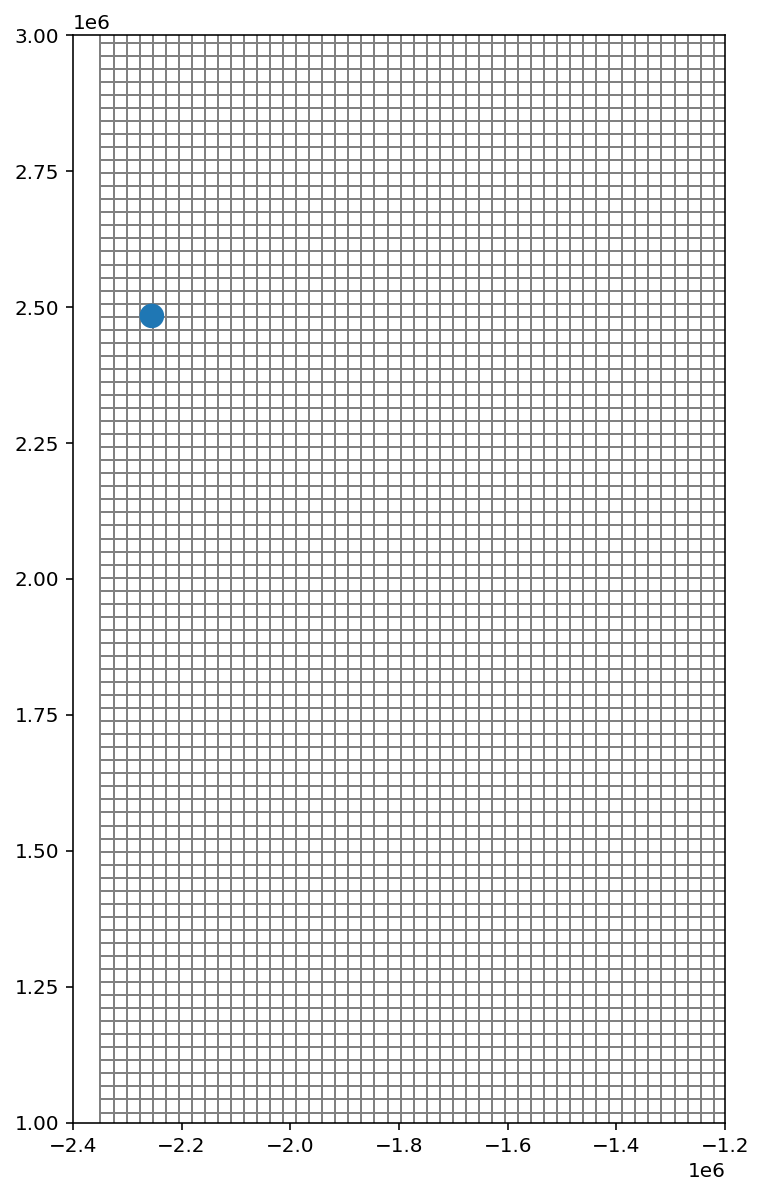

In [19]:
fig, ax= plt.subplots(figsize=(12, 10))

grid, _, _= init_grid(burnarea_data, res= '24km', tot_months= 432);

grid.plot(ax= ax, facecolor= 'None', edgecolor= 'grey');
wildfire_gdf.loc[[11611]].geometry.buffer(np.sqrt(wildfire_gdf.loc[[11611]].final_area_ha*1e4/np.pi)).geometry.plot(ax= ax);
ax.set_ylim(1.0e6, 3.0e6);
ax.set_xlim(-2.4e6, -1.2e6);

In [32]:
clim_fire_24km_gdf= pd.read_hdf('../data/clim_fire_size_24km_data.h5')
clim_fire_24km_gdf[clim_fire_24km_gdf['fire_indx'] == 11611]

,fire_indx,fire_month,fire_size,reg_indx,L4_indx,cell_frac,grid_x,grid_y,Tmax,VPD,...,RH,FM1000,Ant_Tmax,Ant_VPD,Avgprec,Ant_RH,CAPE,Urban,FFWI,Tmin
14215,11611,222,1.605899e+09,5,78f,0.000144,27,3,25.112499,9.820000,...,60.549999,14.247499,17.474167,4.889167,89.555832,69.524170,7.540000,0.037576,13.832500,12.662500
14216,11611,222,1.605899e+09,5,78f,0.000010,29,2,23.549999,7.764999,...,65.834999,16.205000,18.235001,5.033333,75.208328,69.769997,2.650000,0.135143,14.450001,11.850000
14217,11611,222,1.605899e+09,5,78f,0.000008,27,4,27.314999,12.404999,...,54.747501,11.697500,18.054167,5.727500,84.144165,65.585831,9.715000,0.021129,15.287500,12.887500
14218,11611,222,1.605899e+09,5,78f,0.293411,28,3,27.645000,12.527500,...,54.945000,12.012501,18.048332,5.590834,88.754166,66.235001,6.472500,0.023546,17.987499,13.264999
14219,11611,222,1.605899e+09,5,78f,0.209106,29,4,32.082497,18.094999,...,45.697502,9.947500,20.369167,7.687500,40.056667,58.405834,11.547501,0.025243,14.427500,13.090000
14220,11611,222,1.605899e+09,5,78f,0.248530,28,4,30.664999,16.017500,...,48.940002,10.710000,19.781666,7.084167,59.731663,60.628330,11.397500,0.009239,15.424999,13.122499
14221,11611,222,1.605899e+09,5,78f,0.000153,28,2,23.180000,7.505001,...,66.459999,15.455000,17.331667,4.503334,77.599998,71.491669,4.720000,0.055017,19.084999,11.795000
14222,11611,222,1.605899e+09,5,78f,0.248637,29,3,27.135000,11.575001,...,57.532501,12.667500,18.765833,5.851666,67.526665,65.764168,5.075000,0.023485,21.832500,13.032499


## Grid scale climate-fire data

In [2]:
clim_df= init_clim_fire_freq_df(res= '12km', tscale= 'monthly', final_year= 2020, scaled= True, startmon= 444, totmonths= 0) #tscale = 'longterm'
clim_df.to_hdf('../data/clim_fire_freq_12km_w2020_rescaled_data.h5', key= 'df', mode= 'w') #longterm

100%|█████████████████████████████████████| 18593/18593 [11:13<00:00, 27.60it/s]


In [3]:
totdf= init_clim_fire_freq_df(res= '12km', tscale= 'monthly', final_year= 2020)
totdf.to_hdf('../data/clim_fire_freq_12km_w2020_data.h5', key= 'df', mode= 'w')

100%|█████████████████████████████████████| 18593/18593 [11:12<00:00, 27.65it/s]


In [55]:
#clim_df.to_hdf('../data/clim_fire_freq_12km_longterm_data.h5', key= 'df', mode= 'w') 
#clim_df= pd.read_hdf('../data/clim_fire_freq_12km_data.h5')

In [7]:
clim_fire_freq_df= pd.read_hdf('../data/clim_fire_freq_12km_w2020_rescaled_data.h5')
fires_df= pd.read_hdf('../data/clim_fire_size_12km_w2020_data.h5') #fire_size_df.drop_duplicates(subset=['fire_indx']).reset_index().drop(columns= ['index'])  
fire_size_df= fires_df.copy()

In [8]:
for ind in tqdm(range(len(fires_df))):
    sizeind= clim_fire_freq_df[(clim_fire_freq_df.X == fires_df.loc[[ind]]['grid_x'][ind]) & (clim_fire_freq_df.Y == fires_df.loc[[ind]]['grid_y'][ind]) \
                                                                   & (clim_fire_freq_df.month == fires_df.loc[[ind]]['fire_month'][ind])].index[0]
    fire_size_df.iloc[ind, 8:]= clim_fire_freq_df.iloc[sizeind, 0:45]

fire_size_df.to_hdf('../data/clim_fire_size_12km_w2020_rescaled_data.h5', key= 'df', mode= 'w')

100%|█████████████████████████████████████| 32143/32143 [27:37<00:00, 19.39it/s]


## Candidate regions

In [16]:
sierra_gdf= bailey_ecoprovince_shp(region= 'ca_sierra')
sierra_gdf= sierra_gdf.to_crs(epsg= 4326)
scoast_gdf= bailey_ecoprovince_shp(region= 'ca_south_coast')
scoast_gdf= scoast_gdf.to_crs(epsg= 4326)
ncoast_gdf= bailey_ecoprovince_shp(region= 'ca_north_coast')
ncoast_gdf= ncoast_gdf.to_crs(epsg= 4326)
ccoast_gdf= bailey_ecoprovince_shp(region= 'ca_cent_coast')
ccoast_gdf= ccoast_gdf.to_crs(epsg= 4326)

pnw_gdf= bailey_ecoprovince_shp(region= 'pnw_mts')
pnw_gdf= pnw_gdf.to_crs(epsg= 4326)
columbia_plateau_gdf= bailey_ecoprovince_shp(region= 'columbia_plateau')
columbia_plateau_gdf= columbia_plateau_gdf.to_crs(epsg= 4326)

nrockies_gdf= bailey_ecoprovince_shp(region= 'northern_rockies')
nrockies_gdf= nrockies_gdf.to_crs(epsg= 4326)
mrockies_gdf= bailey_ecoprovince_shp(region= 'middle_rockies')
mrockies_gdf= mrockies_gdf.to_crs(epsg= 4326)
srockies_gdf= bailey_ecoprovince_shp(region= 'southern_rockies')
srockies_gdf= srockies_gdf.to_crs(epsg= 4326)

col_plat_gdf= bailey_ecoprovince_shp(region= 'colorado_plateau')
col_plat_gdf= col_plat_gdf.to_crs(epsg= 4326)
am_semidesert_gdf= bailey_ecoprovince_shp(region= 'am_semidesert')
am_semidesert_gdf= am_semidesert_gdf.to_crs(epsg= 4326)
aznm_mts_gdf=  bailey_ecoprovince_shp(region= 'aznm_mts')
aznm_mts_gdf= aznm_mts_gdf.to_crs(epsg= 4326)

im_semidesert_gdf= bailey_ecoprovince_shp(region= 'im_semidesert')
im_semidesert_gdf= im_semidesert_gdf.to_crs(epsg= 4326)
im_desert_gdf= bailey_ecoprovince_shp(region= 'im_desert')
im_desert_gdf= im_desert_gdf.to_crs(epsg= 4326)
ch_desert_gdf= bailey_ecoprovince_shp(region= 'ch_desert')
ch_desert_gdf= ch_desert_gdf.to_crs(epsg= 4326)

ngreat_plains_gdf= bailey_ecoprovince_shp(region= 'northern_great_plains')
ngreat_plains_gdf= ngreat_plains_gdf.to_crs(epsg= 4326)
high_plains_gdf= bailey_ecoprovince_shp(region= 'high_plains')
high_plains_gdf= high_plains_gdf.to_crs(epsg= 4326)
sw_table_gdf= bailey_ecoprovince_shp(region= 'sw_tablelands')
sw_table_gdf= sw_table_gdf.to_crs(epsg= 4326)

In [17]:
forest_area_gdf= pd.concat([sierra_gdf, ncoast_gdf, ccoast_gdf, scoast_gdf, pnw_gdf, nrockies_gdf, mrockies_gdf, srockies_gdf, aznm_mts_gdf], axis= 0)
desert_area_gdf= pd.concat([columbia_plateau_gdf, col_plat_gdf, im_semidesert_gdf, im_desert_gdf, am_semidesert_gdf, ch_desert_gdf, sw_table_gdf], axis= 0)
plains_area_gdf= pd.concat([ngreat_plains_gdf, high_plains_gdf], axis= 0)

In [18]:
forest_freq_all= np.sum([mon_fire_freq(wildfiredf= wildfire_df, regindx= r+1, final_year= 2020).flatten() for r in [0, 1, 2, 3, 4, 6, 7, 8, 10]], axis= 0)
desert_freq_all= np.sum([mon_fire_freq(wildfiredf= wildfire_df, regindx= r+1, final_year= 2020).flatten() for r in [5, 9, 11, 12, 15, 16, 17]], axis= 0)
plains_freq_all= np.sum([mon_fire_freq(wildfiredf= wildfire_df, regindx= r+1, final_year= 2020).flatten() for r in [13, 14]], axis= 0)

fire_file= "../data/burnarea_12km.nc"
forest_size_all= np.sum([mon_burned_area(firefile= fire_file, regindx= r+1, final_year= 2020) for r in [0, 1, 2, 3, 4, 6, 7, 8, 10]], axis= 0)
desert_size_all= np.sum([mon_burned_area(firefile= fire_file, regindx= r+1, final_year= 2020) for r in [5, 9, 11, 12, 15, 16, 17]], axis= 0)
plains_size_all= np.sum([mon_burned_area(firefile= fire_file, regindx= r+1, final_year= 2020) for r in [13, 14]], axis= 0)

In [19]:
yr_arr= np.arange(0, 445, 12)

forest_ann_freq_all= [np.sum(forest_freq_all[yr_arr[i]:yr_arr[i+1]]) for i in range(len(yr_arr) - 1)]
desert_ann_freq_all= [np.sum(desert_freq_all[yr_arr[i]:yr_arr[i+1]]) for i in range(len(yr_arr) - 1)]
plains_ann_freq_all= [np.sum(plains_freq_all[yr_arr[i]:yr_arr[i+1]]) for i in range(len(yr_arr) - 1)]

forest_ann_size_all= [np.sum(forest_size_all[yr_arr[i]:yr_arr[i+1]]) for i in range(len(yr_arr) - 1)]
desert_ann_size_all= [np.sum(desert_size_all[yr_arr[i]:yr_arr[i+1]]) for i in range(len(yr_arr) - 1)]
plains_ann_size_all= [np.sum(plains_size_all[yr_arr[i]:yr_arr[i+1]]) for i in range(len(yr_arr) - 1)]

In [20]:
tot_months= 37*12
month_arr= np.linspace(0, tot_months - 1, tot_months, dtype= int)
year_arr= np.asarray([1984, 1990, 1996, 2002, 2008, 2014, 2020]) #np.linspace(1984, 2019, 6, dtype= int)

ind_grid= [[1, 2, 3], [5, 6, 7], [8, 9, 11], [12, 13, 14]]
reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains"}

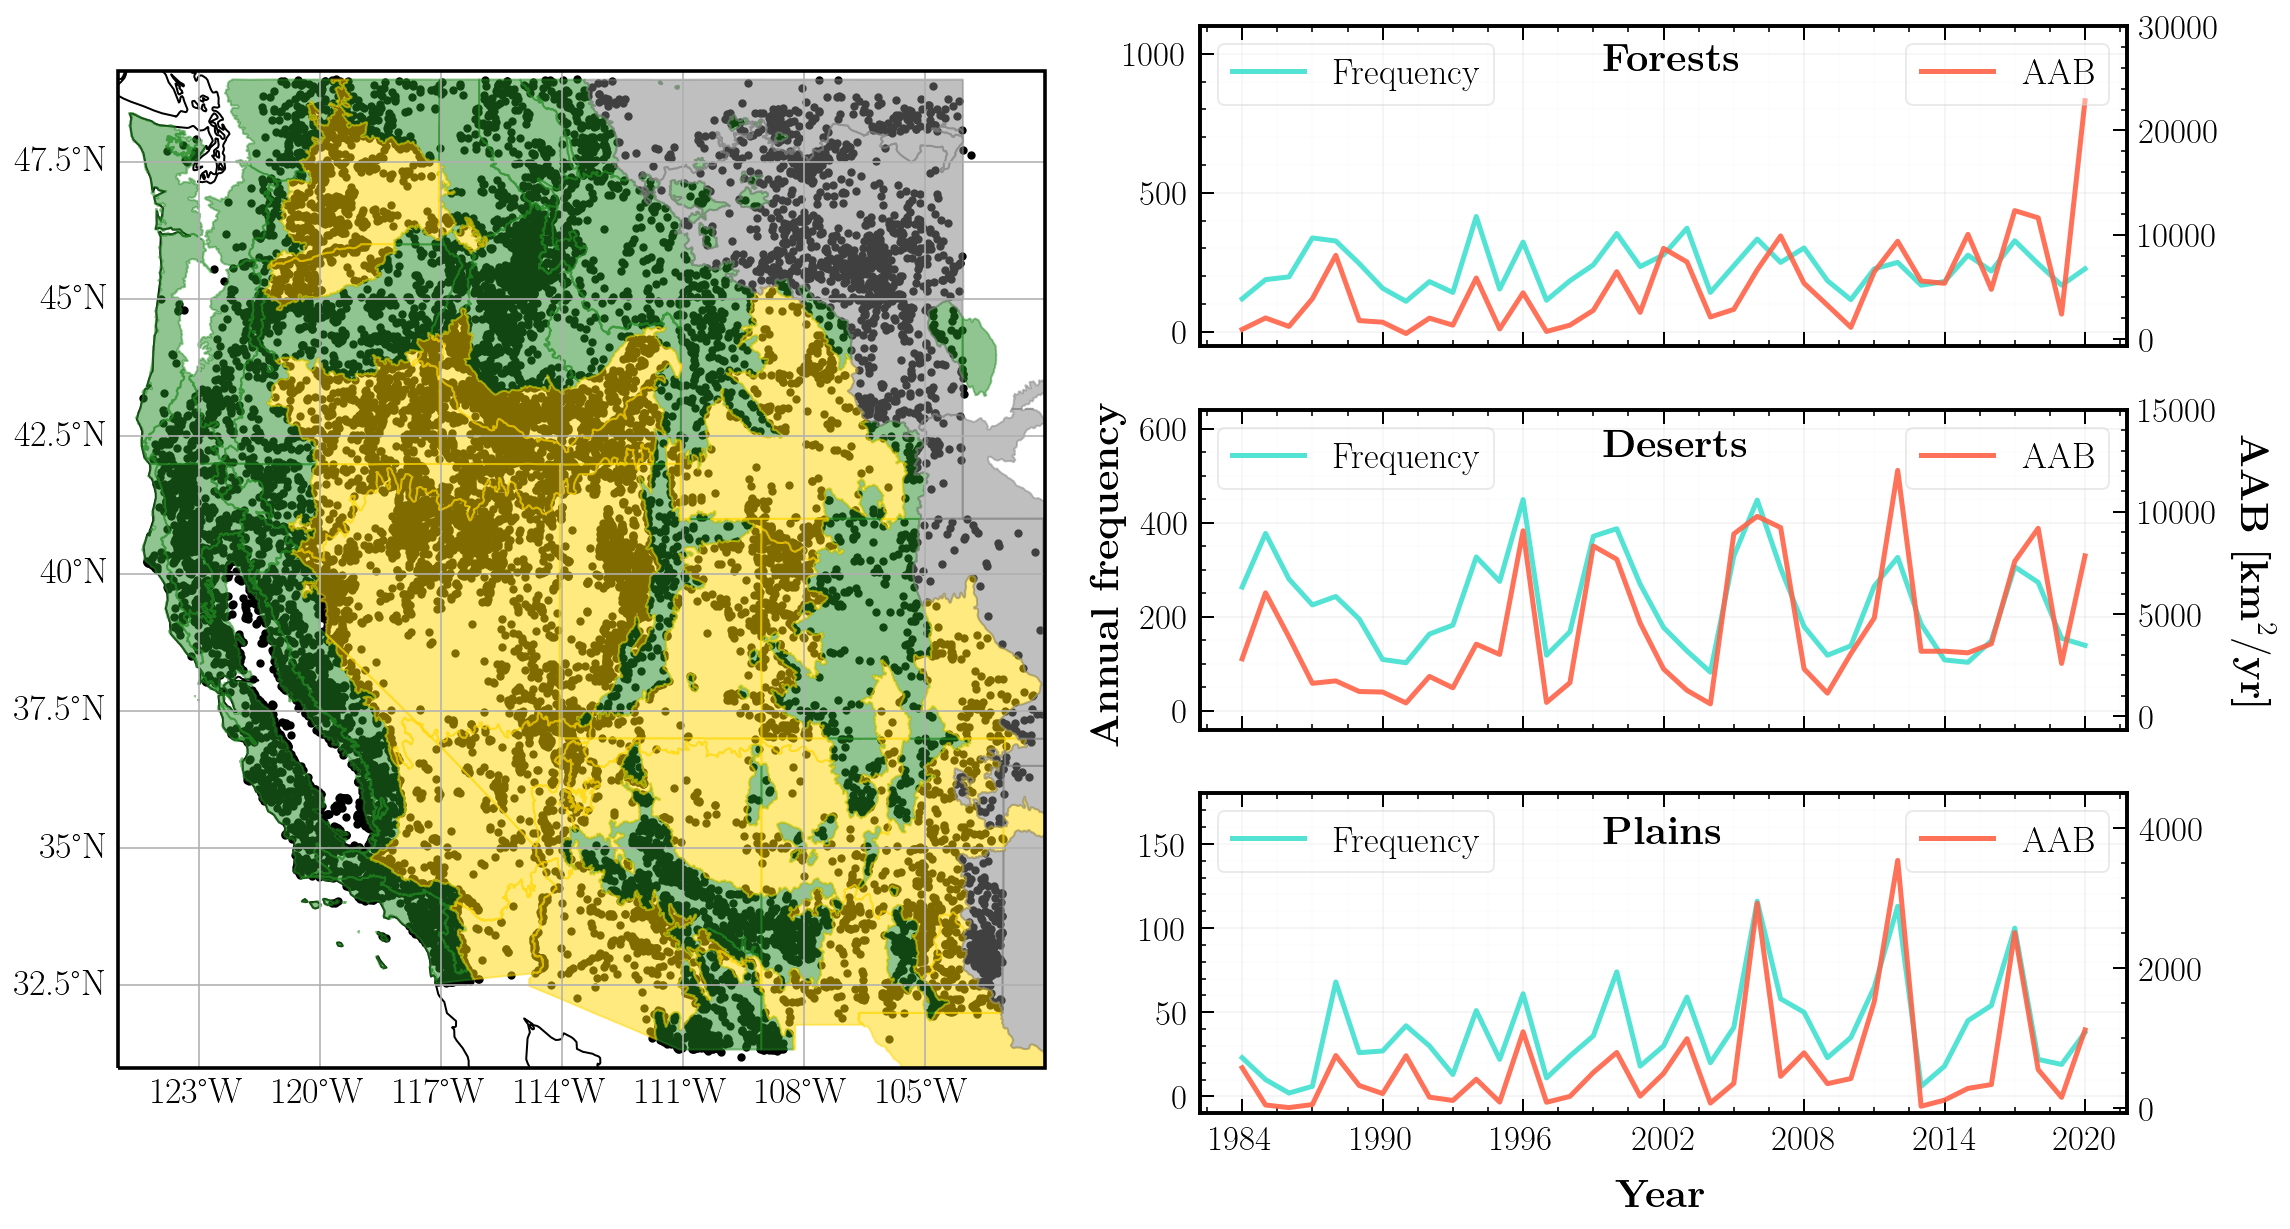

In [119]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
colors= np.random.rand(14)

fig= plt.figure(figsize=(18, 10))
fig.text(0.5, 0.5, r'{\bf Annual frequency}', va='center', rotation='vertical', fontsize= 20);
fig.text(0.72, 0.06, r'{\bf Year}', ha='center', fontsize= 20)
fig.text(0.94, 0.5, r'{\bf AAB [${\bf km}^2/{\bf yr}$]}', va='center', rotation= 270, fontsize= 20);
gs = fig.add_gridspec(3, 4)

ax= fig.add_subplot(gs[0:3, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
#ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor= cfeature.COLORS['water']);
ax.add_geometries(forest_area_gdf.geometry, crs= ccrs.PlateCarree(), color= 'forestgreen', alpha= 0.5, zorder= 1)
ax.add_geometries(desert_area_gdf.geometry, crs= ccrs.PlateCarree(), color= 'gold', alpha= 0.5, zorder= 1)
ax.add_geometries(plains_area_gdf.geometry, crs= ccrs.PlateCarree(), color= 'gray', alpha= 0.5, zorder= 1)
ax.scatter(wildfire_df['final_lon'], wildfire_df['final_lat'], c= 'black', s= 10, transform=ccrs.PlateCarree())
ax.tick_params(labeltop=False, top=False, labelright=False, right=True, which='both', labelsize= 30);

gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
#gl.xlocator = mticker.FixedLocator([-116, -117, -118, -119, -120, -121, -122, -123, -124])
#gl.ylocator = mticker.FixedLocator([34, 36, 38, 40, 42])
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.362/1) 

fig.subplots_adjust(wspace= 0.4)


ax1= fig.add_subplot(gs[0:1, 2:])
ax1_alt= ax1.twinx()
ax1_alt.plot(yr_arr[:-1], forest_ann_size_all, color= 'tomato', label= 'AAB')
ax1.plot(yr_arr[:-1], forest_ann_freq_all, color= 'turquoise', label= 'Frequency');
#ax1_alt.plot(month_arr, forest_size_all, color= 'forestgreen', label= 'MAB')
#ax1.plot(month_arr, forest_freq_all, color= 'turquoise', label= 'Frequency');
ax1.set_ylim(-50, 1100);
ax1_alt.set_ylim(-650, 30000);
ax1.set_xticks((year_arr - 1984)*12);
ax1.set_xticklabels([])
ax1.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax1.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax1.text(185, 940, r"{\bf Forests}", fontsize= 20);
ax1_alt.legend(loc='upper right', frameon= True, fontsize= 18);
ax1.legend(loc='upper left', frameon= True, fontsize= 18);

ax2= fig.add_subplot(gs[1:2, 2:])
ax2_alt= ax2.twinx()
ax2_alt.plot(yr_arr[:-1], desert_ann_size_all, color= 'tomato', label= 'AAB')
ax2.plot(yr_arr[:-1], desert_ann_freq_all, color= 'turquoise', label= 'Frequency');
ax2.set_ylim(-40, 640)
ax2_alt.set_ylim(-650, 15000);
ax2.set_xticks((year_arr - 1984)*12);
ax2.set_xticklabels([])
ax2.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax2.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax2.text(185, 540, r"{\bf Deserts}", fontsize= 20);
ax2_alt.legend(loc='upper right', frameon= True, fontsize= 18);
ax2.legend(loc='upper left', frameon= True, fontsize= 18);

ax3= fig.add_subplot(gs[2:3, 2:])
ax3_alt= ax3.twinx()
ax3_alt.plot(yr_arr[:-1], plains_ann_size_all, color= 'tomato', label= 'AAB')
ax3.plot(yr_arr[:-1], plains_ann_freq_all, color= 'turquoise', label= 'Frequency');
ax3.set_xticks((year_arr - 1984)*12);
ax3.set_xticklabels(year_arr)
ax3.set_ylim(-10, 180);
ax3_alt.set_ylim(-75, 4500);
ax3.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax3.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax3.text(185, 150, r"{\bf Plains}", fontsize= 20);
ax3_alt.legend(loc='upper right', frameon= True, fontsize= 18);
ax3.legend(loc='upper left', frameon= True, fontsize= 18);
#plt.savefig('../paper_plots/intro_plot.png', bbox_inches='tight', dpi= 200);

In [42]:
print("Forests (annual) correlation: %.2f"%stats.pearsonr(forest_ann_freq_all, forest_ann_size_all)[0])
print("Deserts correlation: %.2f"%stats.pearsonr(desert_ann_freq_all, desert_ann_size_all)[0])
print("Plains correlation: %.2f"%stats.pearsonr(plains_ann_freq_all, plains_ann_size_all)[0])

Forests (annual) correlation: 0.47
Deserts correlation: 0.76
Plains correlation: 0.89


In [41]:
print("Forests (monthly) correlation: %.2f"%stats.pearsonr(forest_freq_all, forest_size_all)[0])
print("Deserts correlation: %.2f"%stats.pearsonr(desert_freq_all, desert_size_all)[0])
print("Plains correlation: %.2f"%stats.pearsonr(plains_freq_all, plains_size_all)[0])

Forests (monthly) correlation: 0.70
Deserts correlation: 0.85
Plains correlation: 0.80


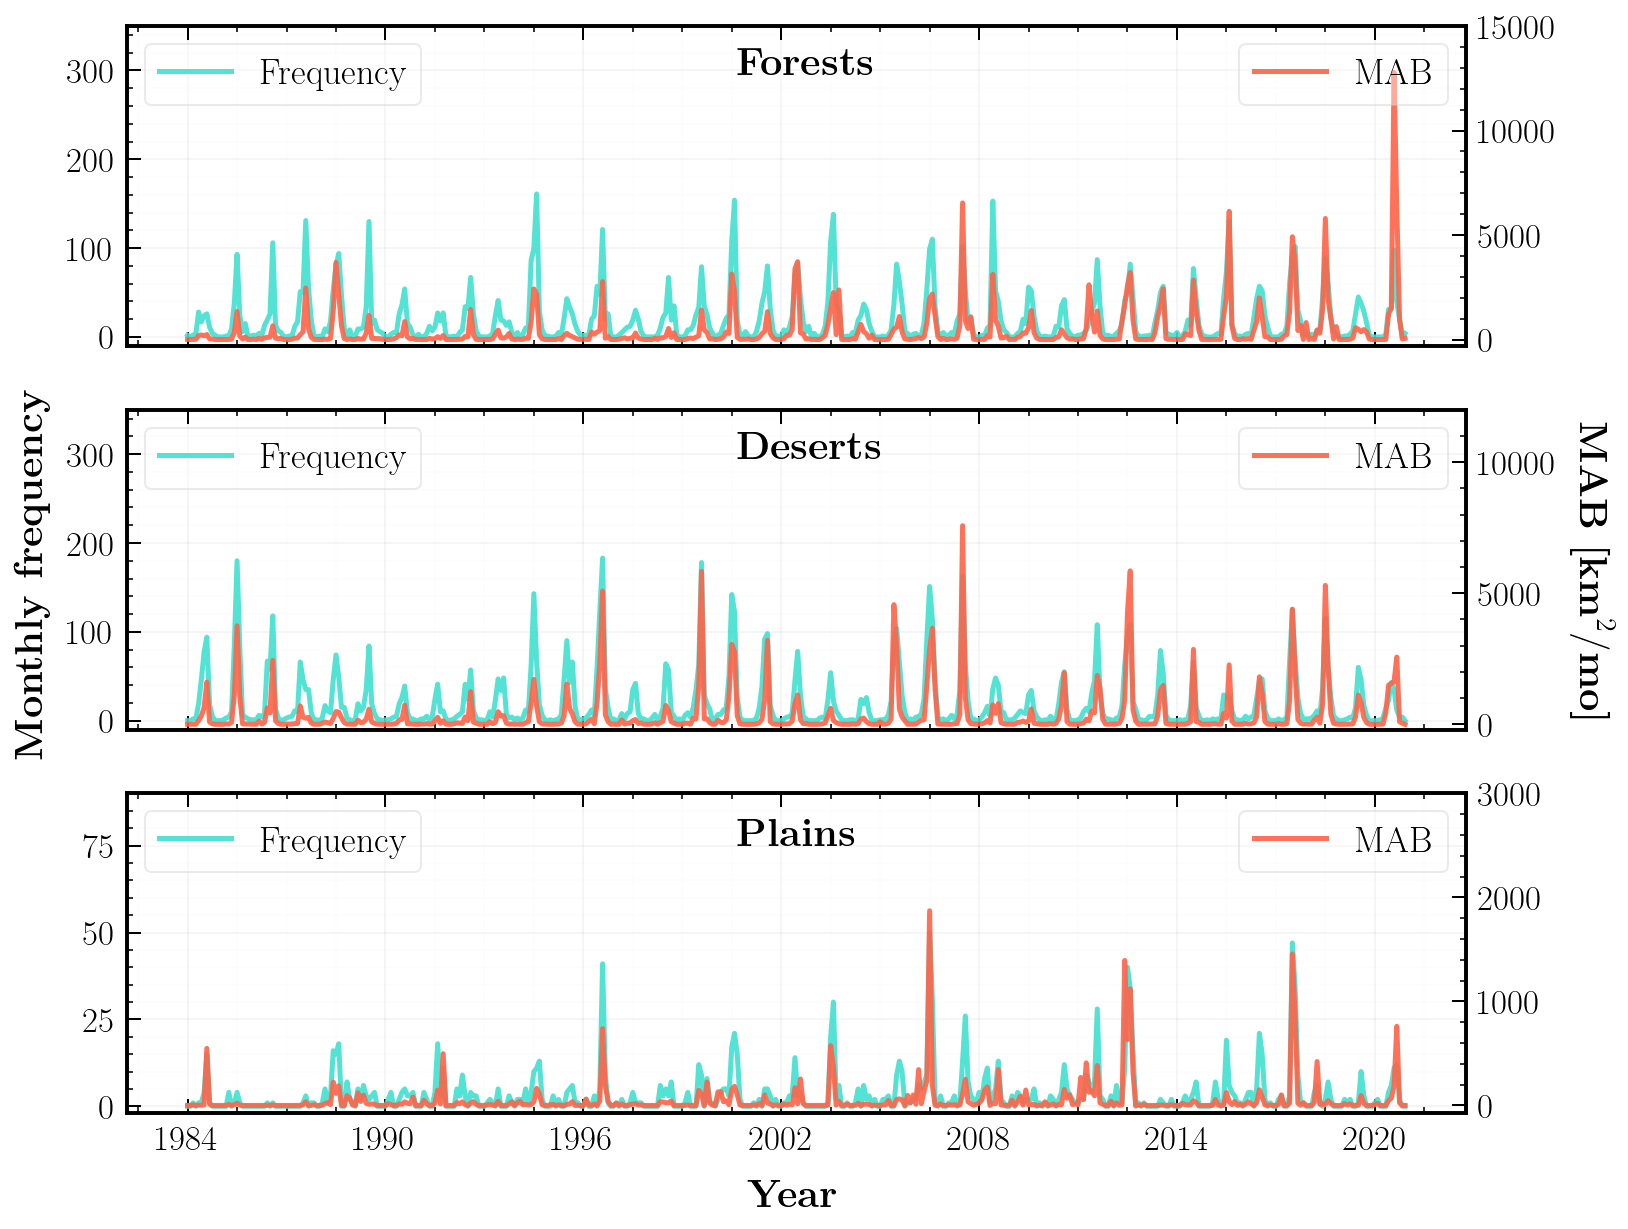

In [147]:
fig= plt.figure(figsize=(12, 10))
fig.text(0.06, 0.5, r'{\bf Monthly frequency}', va='center', rotation='vertical', fontsize= 20);
fig.text(0.51, 0.06, r'{\bf Year}', ha='center', fontsize= 20)
fig.text(0.96, 0.5, r'{\bf MAB [${\bf km}^2/{\bf mo}$]}', va='center', rotation= 270, fontsize= 20);
gs = fig.add_gridspec(3, 4)

ax1= fig.add_subplot(gs[0:1, :])
ax1_alt= ax1.twinx()
ax1_alt.plot(month_arr, forest_size_all, color= 'tomato', label= 'MAB')
ax1.plot(month_arr, forest_freq_all, color= 'turquoise', label= 'Frequency');
ax1.set_ylim(-10, 350);
ax1_alt.set_ylim(-300, 15000);
ax1.set_xticks((year_arr - 1984)*12);
ax1.set_xticklabels([])
ax1.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax1.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax1.text(200, 295, r"{\bf Forests}", fontsize= 20);
ax1_alt.legend(loc='upper right', frameon= True, fontsize= 18);
ax1.legend(loc='upper left', frameon= True, fontsize= 18);

ax2= fig.add_subplot(gs[1:2, :])
ax2_alt= ax2.twinx()
ax2_alt.plot(month_arr, desert_size_all, color= 'tomato', label= 'MAB')
ax2.plot(month_arr, desert_freq_all, color= 'turquoise', label= 'Frequency');
ax2.set_ylim(-10, 350)
ax2_alt.set_ylim(-200, 12000);
ax2.set_xticks((year_arr - 1984)*12);
ax2.set_xticklabels([])
ax2.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax2.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax2.text(200, 295, r"{\bf Deserts}", fontsize= 20);
ax2_alt.legend(loc='upper right', frameon= True, fontsize= 18);
ax2.legend(loc='upper left', frameon= True, fontsize= 18);

ax3= fig.add_subplot(gs[2:3, :])
ax3_alt= ax3.twinx()
ax3_alt.plot(month_arr, plains_size_all, color= 'tomato', label= 'MAB')
ax3.plot(month_arr, plains_freq_all, color= 'turquoise', label= 'Frequency');
ax3.set_xticks((year_arr - 1984)*12);
ax3.set_xticklabels(year_arr)
ax3.set_ylim(-2, 90);
ax3_alt.set_ylim(-75, 3000);
ax3.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
ax3.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
ax3.text(200, 75, r"{\bf Plains}", fontsize= 20);
ax3_alt.legend(loc='upper right', frameon= True, fontsize= 18);
ax3.legend(loc='upper left', frameon= True, fontsize= 18);
#plt.savefig('../paper_plots/intro_plot_alt.pdf', bbox_inches='tight', dpi= 300);

## Monthly fire frequency

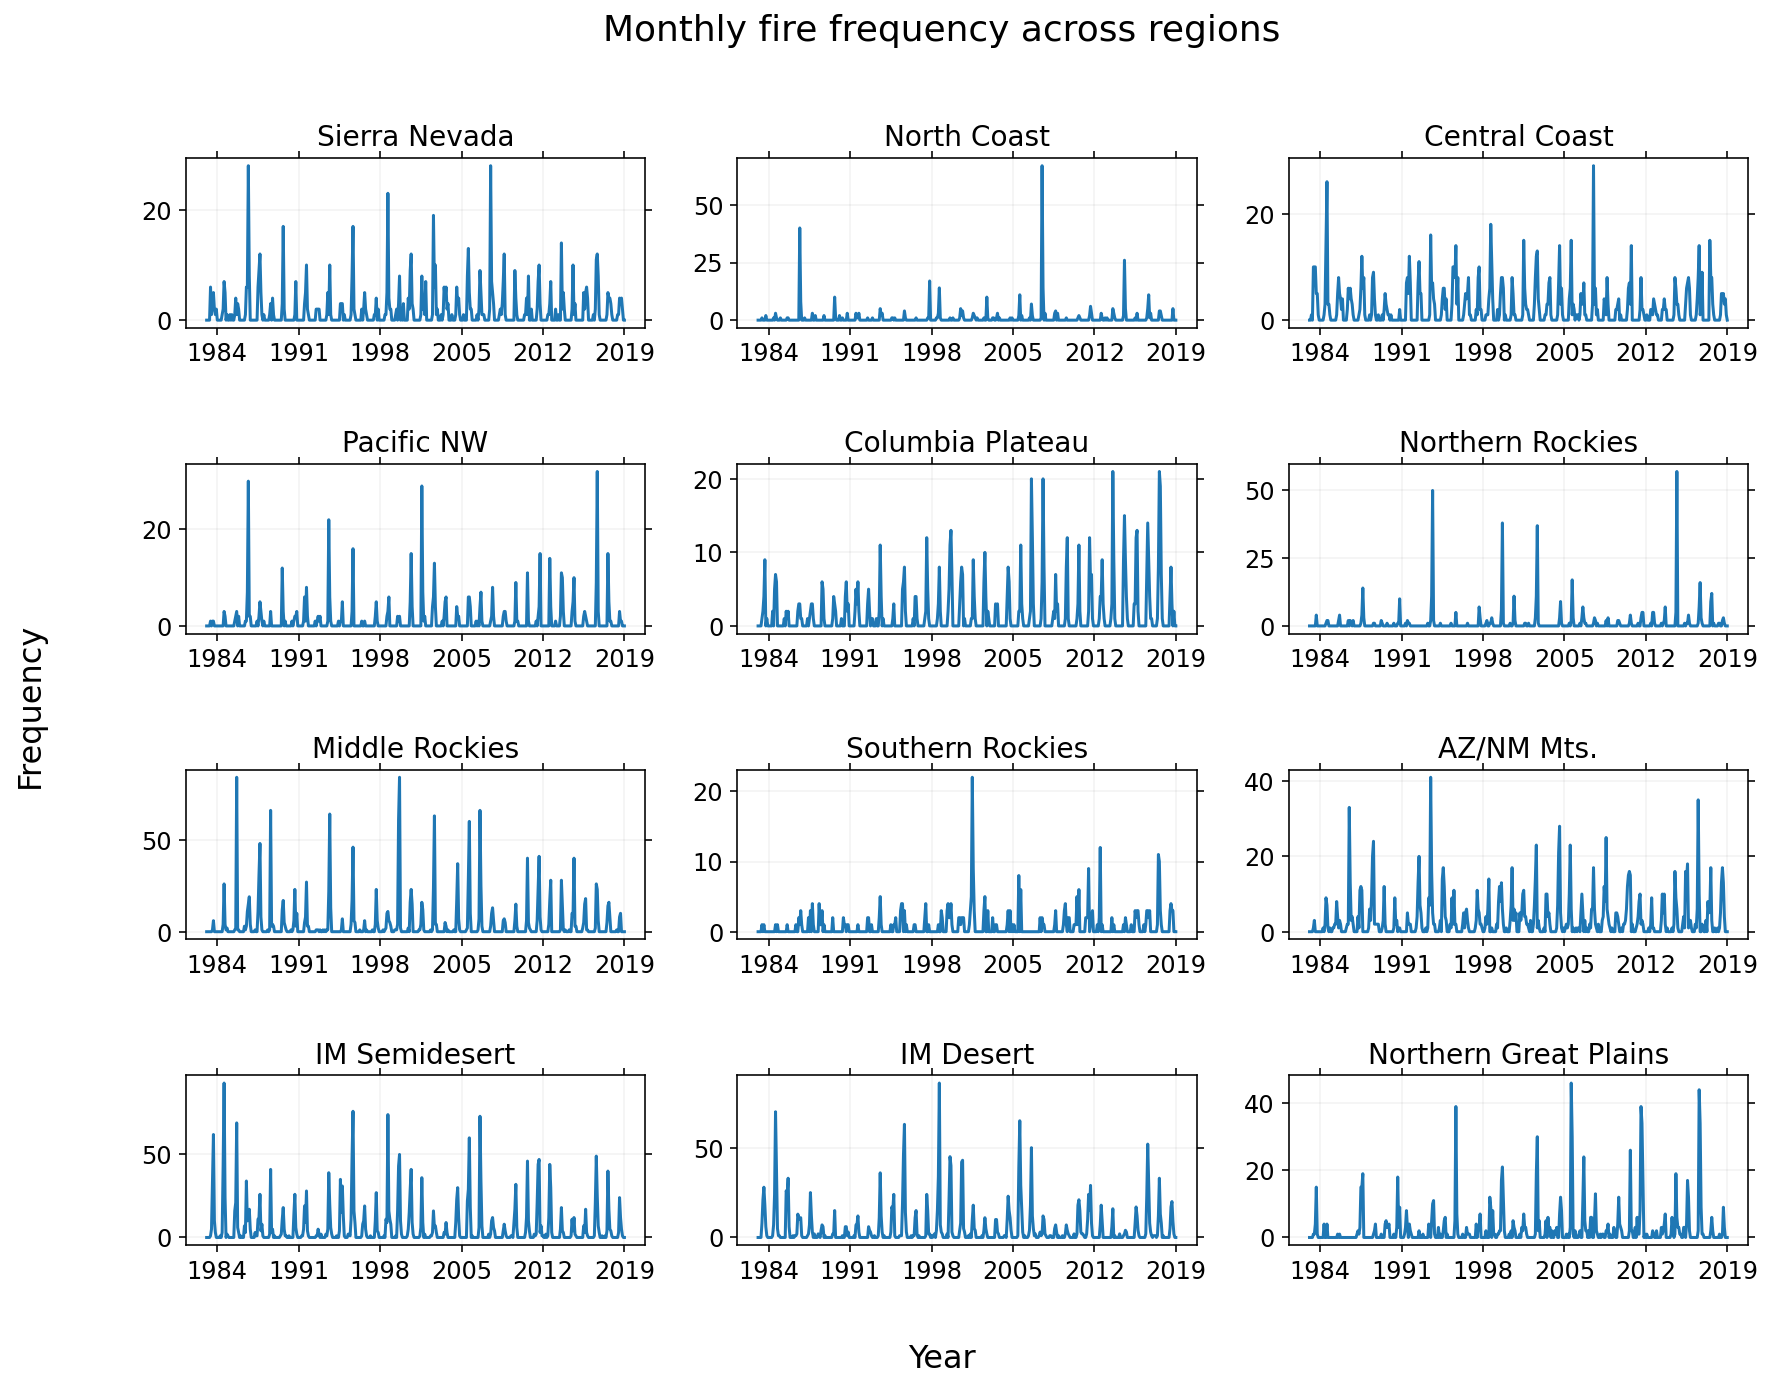

In [6]:
fig, ax= plt.subplots(4, 3, figsize=(14, 10))
plt.suptitle(r'Monthly fire frequency across regions', fontsize= 18);
fig.text(0.04, 0.5, r'Frequency', va='center', rotation='vertical', fontsize= 16);
fig.text(0.5, 0.04, r'Year', ha='center', fontsize= 16)

for i in range(4):
    for j in range(3):
        ax[i, j].plot(month_arr, mon_fire_freq(wildfiredf= wildfire_df, regindx= ind_grid[i][j]).flatten());
        ax[i, j].set_title(reg_name[ind_grid[i][j]], fontsize= 14);
        
        ax[i, j].set_xticks((year_arr - 1984 + 1)*12 - 1);
        ax[i, j].set_xticklabels(year_arr)
            
        fig.subplots_adjust(hspace= 0.8)
        #fig.minorticks_on()
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
        ax[i, j].grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');

#plt.savefig(outfilepath + 'all_region_frequency.pdf', bbox_inches='tight');

## Sandbox

### Consistency checks

* Time series of annual burned area across all regions
* Scatter plot for a given year (in this case 2018) along with regional polygon
* Correlation in years where the VPD is above the 30 year climate mean

In [71]:
sierra_ann_burnarea_group= wildfire_df[wildfire_df['reg_indx'] == 1].groupby(['final_year'])
ncoast_ann_burnarea_group= wildfire_df[wildfire_df['reg_indx'] == 2].groupby(['final_year'])
ccoast_ann_burnarea_group= wildfire_df[wildfire_df['reg_indx'] == 3].groupby(['final_year'])
scoast_ann_burnarea_group= wildfire_df[wildfire_df['reg_indx'] == 4].groupby(['final_year'])

In [79]:
#consistency check for a given year, 1984, before generalizing to all years

tmp_burnarea_arr= []
tmp_burnarea_arr.append(sierra_ann_burnarea_group.get_group(1984)['final_area_ha'].to_numpy())
tmp_burnarea_arr.append(ncoast_ann_burnarea_group.get_group(1984)['final_area_ha'].to_numpy())
tmp_burnarea_arr.append(ccoast_ann_burnarea_group.get_group(1984)['final_area_ha'].to_numpy())
tmp_burnarea_arr.append(scoast_ann_burnarea_group.get_group(1984)['final_area_ha'].to_numpy())
tmp_ca_ann_burnarea= np.sum(np.hstack(tmp_burnarea_arr))/100

print("Total CA burned area (in km^2): %.2f"%tmp_ca_ann_burnarea)

Total CA burned area (in km^2): 633.43


In [81]:
sierra_ann_burnarea_check= np.asarray(([np.sum(sierra_ann_burnarea_group.get_group(i)['final_area_ha'])/100 \
                                                                                for i in list(sierra_ann_burnarea_group.groups.keys())]))
ncoast_ann_burnarea_check= np.asarray(([np.sum(ncoast_ann_burnarea_group.get_group(i)['final_area_ha'])/100 \
                                                                                for i in list(ncoast_ann_burnarea_group.groups.keys())]))
ccoast_ann_burnarea_check= np.asarray(([np.sum(ccoast_ann_burnarea_group.get_group(i)['final_area_ha'])/100 \
                                                                                for i in list(ccoast_ann_burnarea_group.groups.keys())]))
scoast_ann_burnarea_check= np.asarray(([np.sum(scoast_ann_burnarea_group.get_group(i)['final_area_ha'])/100 \
                                                                                for i in list(scoast_ann_burnarea_group.groups.keys())]))

ca_ann_burnarea_check= sierra_ann_burnarea_check + ncoast_ann_burnarea_check + ccoast_ann_burnarea_check + scoast_ann_burnarea_check

In [85]:
np.sum(ca_ann_burnarea_check[:-2])

54733.043600000005

In [89]:
np.sum(wildfire_df['final_area_ha'])/100

353303.0085

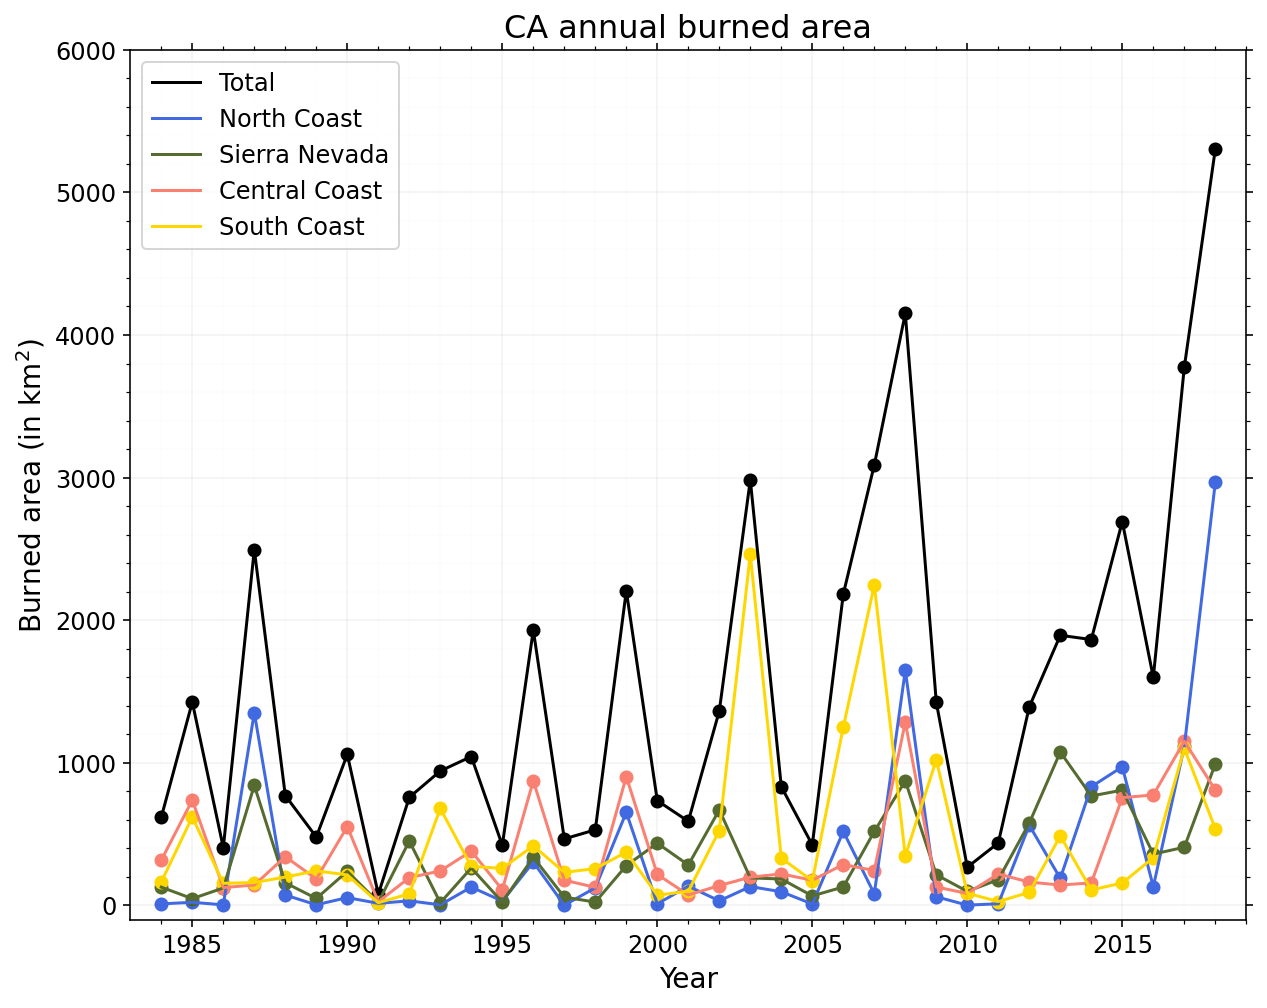

In [73]:
fig, ax= plt.subplots(figsize=(10, 8))

tot_months= len(ca_ann_burnarea_check) - 2
ax.scatter(np.linspace(1984, 2018, tot_months), ca_ann_burnarea_check[:-2], color= 'black');
ax.plot(np.linspace(1984, 2018, tot_months), ca_ann_burnarea_check[:-2], color= 'black', label= 'Total');
ax.scatter(np.linspace(1984, 2018, tot_months), ncoast_ann_burnarea_check[:-2], color= 'royalblue');
ax.plot(np.linspace(1984, 2018, tot_months), ncoast_ann_burnarea_check[:-2], color= 'royalblue', label= 'North Coast');
ax.scatter(np.linspace(1984, 2018, tot_months), sierra_ann_burnarea_check[:-2], color= 'darkolivegreen');
ax.plot(np.linspace(1984, 2018, tot_months), sierra_ann_burnarea_check[:-2], color= 'darkolivegreen', label= 'Sierra Nevada');
ax.scatter(np.linspace(1984, 2018, tot_months), ccoast_ann_burnarea_check[:-2], color= 'salmon');
ax.plot(np.linspace(1984, 2018, tot_months), ccoast_ann_burnarea_check[:-2], color= 'salmon', label= 'Central Coast');
ax.scatter(np.linspace(1984, 2018, tot_months), scoast_ann_burnarea_check[:-2], color= 'gold');
ax.plot(np.linspace(1984, 2018, tot_months), scoast_ann_burnarea_check[:-2], color= 'gold', label= 'South Coast');

ax.set_xlim(1983, 2019);
ax.set_xlabel(r'Year', fontsize= 14);
ax.set_ylim(-100, 6000);
ax.set_ylabel(r'Burned area (in ${\rm km}^2$)', fontsize= 14);

plt.minorticks_on();
plt.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 12);
plt.grid(b=True, which='major', color='black', alpha=0.05, linestyle='-');
plt.grid(b=True, which='minor', color='black', alpha=0.01, linestyle='-');
plt.legend(loc='upper left', frameon=True, fontsize=12);

ax.set_title(r'CA annual burned area', fontsize= 16);
#plt.savefig(outfilepath + 'ca_ann_burned_area.pdf', bbox_inches='tight');

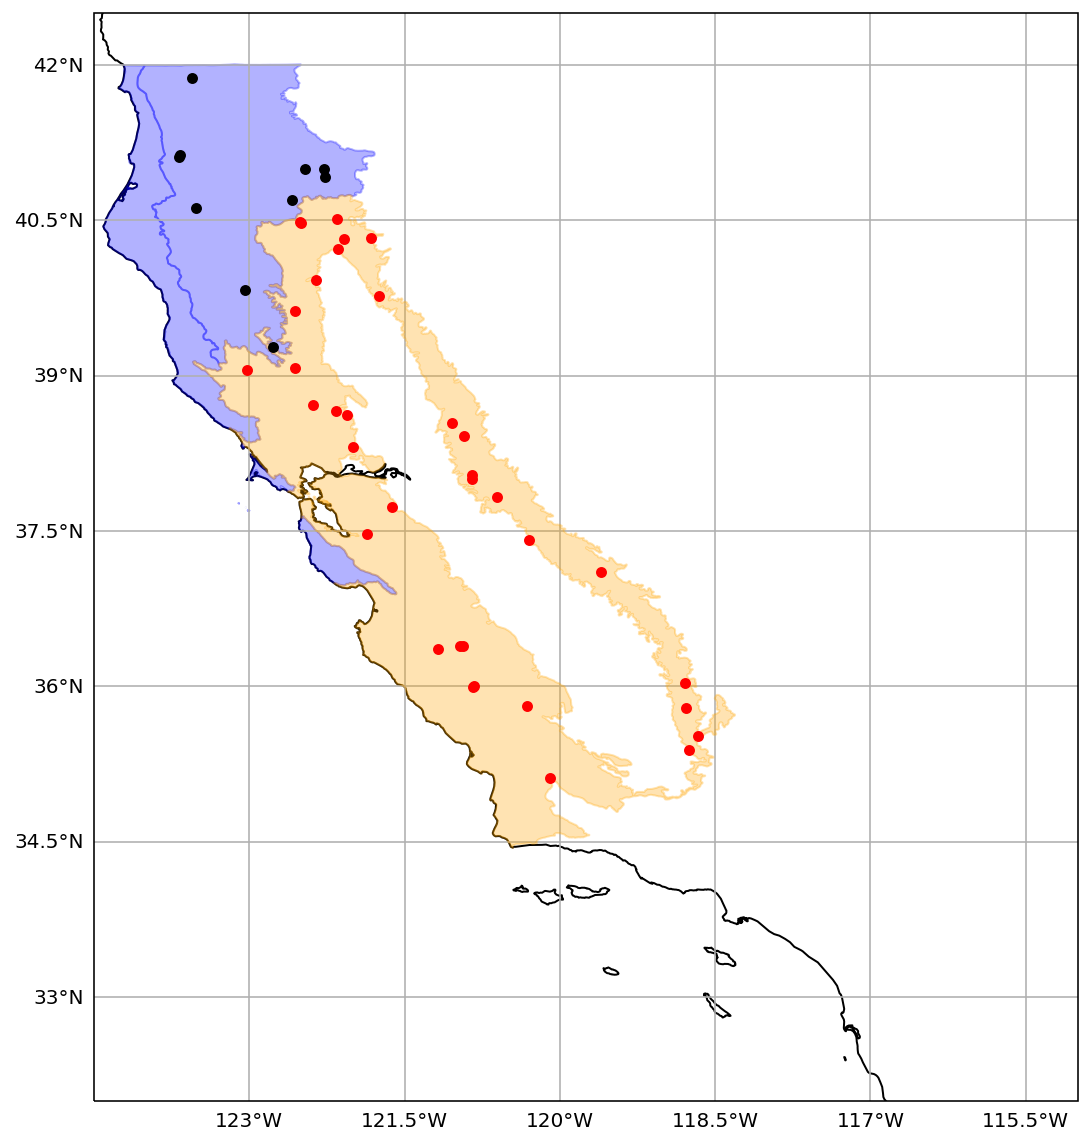

In [153]:
extent = [-124.5, -115, 32, 42.5] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

fig= plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
#ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor= cfeature.COLORS['water']);
ax.add_geometries(ncoast_gdf.geometry, crs= ccrs.PlateCarree(), color= 'blue', alpha= 0.3, zorder= 1)
ax.add_geometries(ccoast_gdf.geometry, crs= ccrs.PlateCarree(), color= 'orange', alpha= 0.3, zorder= 2)
ax.scatter(ncoast_ann_burnarea_group.get_group(2018)['final_lon'], ncoast_ann_burnarea_group.get_group(2018)['final_lat'], \
                                                        c= 'black', s= 20, transform=ccrs.PlateCarree(), zorder= 10)
ax.scatter(ccoast_ann_burnarea_group.get_group(2018)['final_lon'], ccoast_ann_burnarea_group.get_group(2018)['final_lat'], \
                                                        c= 'red', s= 20, transform=ccrs.PlateCarree(), zorder= 10)
# CS = ax.contourf(lat_long_fire_grid[1], lat_long_fire_grid[0], np.sum(burnarea_ccoast_data.values[ind_2018], axis= 0), cmap=plt.cm.inferno, zorder= 20)
# cbar= fig.colorbar(CS, ax= ax, shrink= 0.8)
# cbar.ax.set_ylabel(r'Burned area (in ${\rm km}^2$)', fontsize= 14, labelpad= 10, rotation= 270)

gl= ax.gridlines(draw_labels=True);
#gl.xlocator = mticker.FixedLocator([-116, -117, -118, -119, -120, -121, -122, -123, -124])
#gl.ylocator = mticker.FixedLocator([34, 36, 38, 40, 42])
gl.top_labels = False
gl.right_labels = False

#plt.savefig(outfilepath + 'ca_nccoast_fires.pdf', bbox_inches='tight');

In [28]:
freq_sierra= mon_fire_freq(wildfiredf= wildfire_df, regindx= 1, threshold= False).flatten()
freq_pnw= mon_fire_freq(wildfiredf= wildfire_df, regindx= 5, threshold= False).flatten()
vpd_sierra= clim_pred_var(pred_file_indx= 2, pred_seas_indx= 1, regindx= 1, burnarr_len= 10)

sum_indx_1, sum_indx_2= tindx_func(startmon= 3, duration= 8)
sum_freq_sierra= np.asarray([np.sum(freq_sierra[sum_indx_1[i]:sum_indx_2[i]]) for i in range(len(sum_indx_1))])
sum_freq_pnw= np.asarray([np.sum(freq_pnw[sum_indx_1[i]:sum_indx_2[i]]) for i in range(len(sum_indx_1))])
ext_flag= np.where(vpd_sierra >= np.mean(vpd_sierra))

vpd_sierra= vpd_sierra[ext_flag]
sum_freq_sierra= sum_freq_sierra[ext_flag]

pred_var_sierra, pred_freq_sierra, r_sierra= uni_lsq_regression_model(sum_freq_sierra, pred_file_indx= 2, pred_seas_indx= 1, regindx= 1, freq_flag= True)
pred_var_pnw, pred_freq_pnw, r_pnw= uni_lsq_regression_model(sum_freq_pnw, pred_file_indx= 2, pred_seas_indx= 1, regindx= 5, freq_flag= True)

np.sqrt(r_sierra), np.sqrt(r_pnw)

### Sliding window tests

In [24]:
test_arr= np.asarray([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])

In [25]:
sliding_window_view(test_arr, (2, 2), axis= (0, 1))

array([[[[ 1,  2],
         [ 5,  6]],

        [[ 2,  3],
         [ 6,  7]],

        [[ 3,  4],
         [ 7,  8]]],


       [[[ 5,  6],
         [ 9, 10]],

        [[ 6,  7],
         [10, 11]],

        [[ 7,  8],
         [11, 12]]],


       [[[ 9, 10],
         [13, 14]],

        [[10, 11],
         [14, 15]],

        [[11, 12],
         [15, 16]]]])

In [28]:
np.mean(sliding_window_view(test_arr, (2, 2), axis= (0, 1)), axis= (2, 3))

array([[ 3.5,  4.5,  5.5],
       [ 7.5,  8.5,  9.5],
       [11.5, 12.5, 13.5]])

In [27]:
np.mean(sliding_window_view(test_arr, (2, 2), axis= (0, 1)), axis= (2, 3))[::2, ::2]

array([[ 3.5,  5.5],
       [11.5, 13.5]])

### CRPS score

In [2]:
from ml_utils import *
import properscoring as ps

In [115]:
ps.crps_gaussian(0, mu=10, sig= 1)

9.435810416452243

In [120]:
ps.crps_ensemble(tf.constant([1.0, 2.0, 3.0]), tf.constant([0., 0., 0.])).mean()

2.0

In [118]:
obs = [-2, -1, 0, 1, 2]
baseline_score = ps.crps_ensemble(obs, [0, 0, 0, 0, 0]).mean()
forecast_score = ps.crps_gaussian(obs, mu=0, sig=1).mean()
skill = (baseline_score - forecast_score) / baseline_score

In [121]:
ps.crps_ensemble(obs, [0, 0, 0, 0, 0])

array([2, 1, 0, 1, 2])

In [109]:
samps_1= zinb_model(tf.reshape([[0.5, 10, 10], [0.6, 9, 20]], (2, 3))).sample(1000)
samps_2= zinb_model(tf.reshape([[0.5, 10, 10], [0.6, 9, 20]], (2, 3))).sample(1000)

In [111]:
tf.multiply(tf.constant(-0.5, dtype= tf.float32), tf.reduce_mean(tf.abs(samps_1 - samps_2), axis= 0))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ -3.178, -11.984], dtype=float32)>

In [114]:
tf.reduce_mean(tf.abs(samps_1 - tf.constant([20.0, 20.0])), axis= 0)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([14.923, 22.007], dtype=float32)>